# Using Clustering to Inform Supervised Learning

## Problem Statement:

We want to build a regression model that shows expected production from an oil well **during normal production**

### Challenge:

We have good data to show oil well production, but this does not just show when the oil well is working. It also includes data from periods when the well is down (not producing), producing less than expectd, or producing more than expected.

To model periods of normal production, we must first identify "normal" production, and fit a model only to these data points.  

Unfortunately, we do not have a label to indicate when the well is in normal production.  Therefore, to to generate these labels, we need to use unsupervised learning.

## Generate Some Data:

Let's generate some synthetic data:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression as LR
np.random.seed(42)

class Decline_Generator():
    '''This class creates synthetic gas production data with dropouts, low point, high points and noise.
    Return data is a pandas dataframe with columns "date" and "production'''
    def __init__(self, n = 365*2, drops = (0,0), 
    noise = 0, highpoints = (0,0), lowpoints = (0,0), decline_rate = .996):
        dates = pd.date_range(start = '2018-01-01', end = '2019-01-01', periods = n)
        
        x = 100
        production = []
        
        for _ in range(n):
            production.append(x)
            x*=decline_rate
            
        production = np.array(production) + np.random.random(size = n)*noise

        for i in range(highpoints[0]):
            index = np.random.randint(n)
            production[index] += highpoints[1]

        for i in range(lowpoints[0]):
            index = np.random.randint(n)
            production[index] -= lowpoints[1]

        for i in range(drops[0]):
            start = np.random.randint(n-drops[1])
            production[start:start+drops[1]] = 0
            
        production += np.random.random(size = n)*noise
        production[production <=1] = 1.1
        
        data = pd.DataFrame({'date':dates,'production':production})
        data['date'] = pd.to_datetime(data['date'].dt.date)
        
        
        self.data = data    

## An ideal oil well:

Ideally, an oil well would show predictable, normal production:

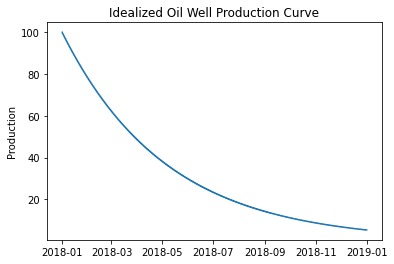

In [2]:
data = Decline_Generator().data

plt.plot(data['date'],data['production'])
plt.ylabel('Production')   
plt.title('Idealized Oil Well Production Curve');

## Real Oil Well Production

A real oil well is likely to have periods of high, normal, low and zero production:


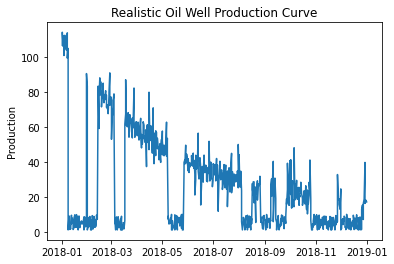

In [3]:
data = Decline_Generator(drops = (15,25), noise = 10, highpoints = (35,20), lowpoints = (25,20)).data

plt.plot(data['date'],data['production'])
plt.ylabel('Production')   
plt.title('Realistic Oil Well Production Curve');

## Simple Fitting

If we fit a simple linear model to all the data, it doesn't work well because it fits to both the "normal" production and the abnormal production

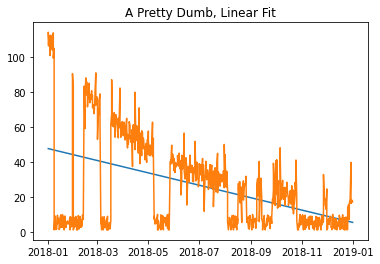

In [4]:
from sklearn.linear_model import LinearRegression as LR
linear = LR().fit(data[['date']].astype(int),data['production'] )
plt.plot(data['date'], linear.predict(data[['date']].astype(int)))
plt.plot(data['date'], data['production'])
plt.title('A Pretty Dumb, Linear Fit');

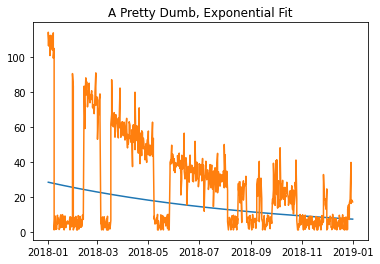

In [5]:
exp_model = LR().fit(data[['date']].astype(int),np.log(data['production'] ))
plt.plot(data['date'], np.exp(exp_model.predict(data[['date']].astype(int))))
plt.plot(data['date'], data['production'])
plt.title('A Pretty Dumb, Exponential Fit');

## Non-Linear Regression:

Using a non-linear Regression doesn't help. It does a better job of fitting all the data, but is not helpful for identifying ideal production. I.e.: when the model production drops to zero, the prediction line also drops to zero. We want that line to show where the production *should be*, not where it is.

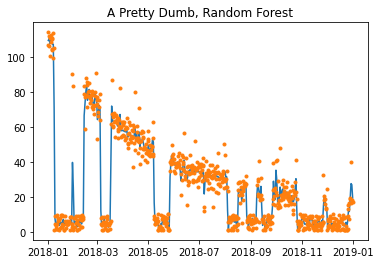

In [6]:
from sklearn.ensemble import RandomForestRegressor as RFR
rfr = RFR(n_estimators = 10, max_depth=10).fit(data[['date']].astype(int), data['production'] )
plt.plot(data['date'], rfr.predict(data[['date']].astype(int)))
plt.plot(data['date'], data['production'], marker = '.', linestyle = '')
plt.title('A Pretty Dumb, Random Forest');

## Solution:

To solve this problem, we will use **unsupervised learning** to identify different types of production, then fit a regression model *only to the normal data points*.

First, we have to engineer some additional features:

In [7]:
X = data.copy()

X['production'] = np.log(X['production'])

'''Add Delta Columns for differences''' 
for i in range(-4,5):
    X['delta{}'.format(i)] = X.production.diff(i)

X['days_ago'] = (X['date'].max()-X['date']).dt.days
X['epsilon'] = X['days_ago']/X['production']

X = X.drop(['date','days_ago'], axis = 1).reset_index()
X = X.dropna()
indices = X['index']
X.drop('index',axis = 1, inplace = True)

In [8]:
X.head()

,production,delta-4,delta-3,delta-2,delta-1,delta0,delta1,delta2,delta3,delta4,epsilon
4,4.708870,0.001104,0.020480,-0.012120,0.096722,0.0,-0.009374,0.045422,-0.027363,0.039633,77.088552
5,4.612149,-0.038065,-0.095617,-0.076242,-0.108841,0.0,-0.096722,-0.106095,-0.051300,-0.124084,78.705178
6,4.720990,0.016636,0.070776,0.013224,0.032600,0.0,0.108841,0.012120,0.002746,0.057541,76.678831
7,4.688390,0.046712,-0.015963,0.038176,-0.019376,0.0,-0.032600,0.076242,-0.020480,-0.029854,77.212000
8,4.707766,-0.025336,0.066088,0.003412,0.057552,0.0,0.019376,-0.013224,0.095617,-0.001104,76.681802


## Cluster the Data Points into 6 Clusters

In [9]:
X = PCA(n_components = int(len(X.columns)/1.5), whiten = True).fit_transform(X)

labels = KMeans(n_clusters =6).fit(X).predict(X)
data['labels'] = -1
data.iloc[indices,-1] = labels
data = data[data['labels']>=0]

## Assume the majority class is "normal production"

In [10]:
majority_class = data['labels'].value_counts().index[0]
majority = data[data['labels']==majority_class]

## Fit a model only on the normal production data

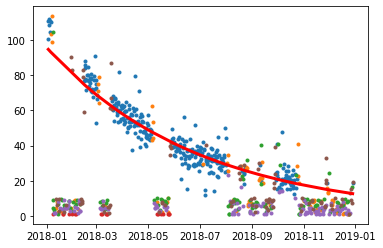

In [12]:
model = LR().fit(majority['date'].values.reshape(-1,1), np.log(majority['production']))
predictions = np.exp(model.predict(majority['date'].values.astype(float).reshape(-1,1)))

for label in data['labels'].unique():
    l = data[data['labels'] == label]
    plt.scatter(l['date'], l['production'], marker = '.')

plt.plot(majority['date'], predictions, linewidth = 3, color = 'r');


## Conclusion:

We have sucessfully fit a model to the normal production data. 